In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.spatial.distance import cdist
import numpy as np

df = pd.read_csv("DataFrame.csv", encoding="utf-8")

## 1.1 -  Machine Learning non supervisé : Clustering avec KMeans

L'objectif ici est d'identifier des groupes naturels de vulnérabilités en fonction de leur niveau de criticité (CVSS) et de leur probabilité d'exploitation (EPSS).
L'objectif est de détecter des profils types de menaces pour prioriser les alertes ou adapter les actions de sécurité

Variables choisies : 
- CVSS_score : indicateur de la gravité technique de la vulnérabilité
- EPSS_score : probabilité que la faille soit exploitée

Comme nous avons pu le voir lors de l'étape 5, ces deux variables sont complémentaires et permettent de regrouper les failles en fonction de leur dangerosité réelle.

Nous avons choisi l’algorithme KMeans, car :

- il est simple à implémenter
- il est adapté aux données numériques continues comme CVSS_score (gravité technique) et EPSS_score (probabilité d’exploitation)
- il permet de regrouper les vulnérabilités en catégories pertinentes sans supervision humaine



## 1.2 - Validation de notre modèle non supervisé (KMeans) : 

Afin de valider la qualité de notre modèle non supervisé KMeans, nous allons utilisé 3 indicateurs de validation internes :

- Score de silhouette : mesure dans quelle mesure chaque point est plus proche de son propre cluster que des autres. Il varie de -1 à 1. Un score proche de 1 indique un clustering bien formé

- Indice de Davies-Bouldin : mesure le rapport entre la compacité des clusters et leur séparation. Plus l’indice est bas, meilleure est la séparation entre les groupes

- Indice de Calinski-Harabasz : évalue le rapport entre la dispersion inter-clusters et la dispersion intra-clusters. Plus il est élevé, plus les clusters sont bien distincts

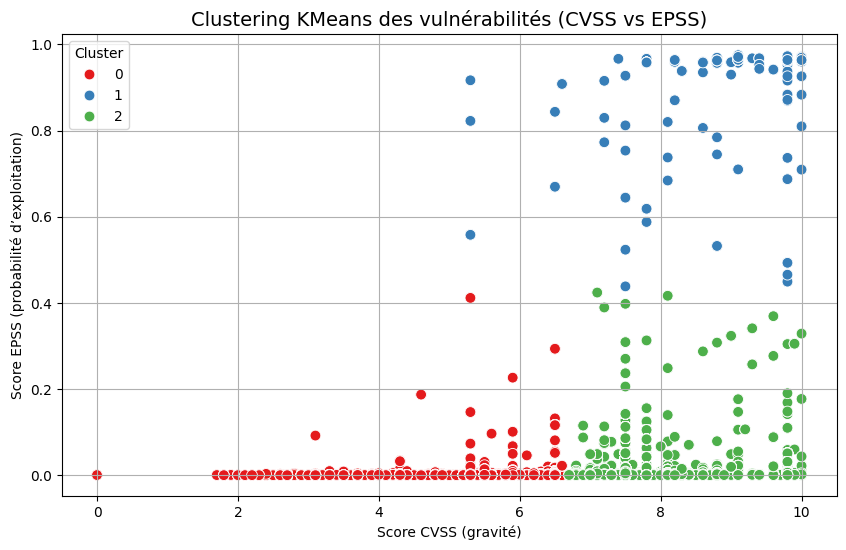

Silhouette Score : 0.6006
Calinski-Harabasz Index : 74055.47
Davies-Bouldin Index : 0.4624


In [ ]:
# Non supervisé - KMeans

df_cluster = df[["CVSS_score", "EPSS_score"]].copy() #on garde uniquement les colonnes utiles
df_cluster.dropna(inplace=True) #on retire les lignes où l'une des deux colonnes est manquante

#normalisation des données 
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_cluster)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(data_scaled)
df_cluster["Cluster"] = clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="CVSS_score",
    y="EPSS_score",
    hue="Cluster",
    palette="Set1",
    data=df_cluster,
    s=60
)
plt.title("Clustering KMeans des vulnérabilités (CVSS vs EPSS)", fontsize=14)
plt.xlabel("Score CVSS (gravité)")
plt.ylabel("Score EPSS (probabilité d’exploitation)")
plt.grid(True)
plt.legend(title="Cluster")
plt.show()




# VALIDATION DU CLUSTERING 

# 1. Silhouette Score
silhouette = silhouette_score(data_scaled, clusters)
print(f"Silhouette Score : {silhouette:.4f}")

# 2. Calinski-Harabasz Index
calinski = calinski_harabasz_score(data_scaled, clusters)
print(f"Calinski-Harabasz Index : {calinski:.2f}")

# 3. Davies-Bouldin Index (plus petit = meilleur)
davies = davies_bouldin_score(data_scaled, clusters)
print(f"Davies-Bouldin Index : {davies:.4f}")


Nous avons appliqué KMeans avec 3 clusters, ce qui a révélé trois types de vulnérabilités :

- Cluster 0 (rouge) : Ce groupe contient principalement des vulnérabilités peu critiques (CVSS bas à moyen) et très peu exploitable (EPSS très faible). Ces vulnérabilités sont donc à un faible risque et peu prioritaire

- Cluster 1 (bleu) : Ce groupe représente des vulnérabilités graves et critiques (CVSS élevés) et fortement exploitables (EPSS élevé). Il représente les vulnérabilités à traiter en priorité

- Cluster 2 (vert) : Ce groupe contient les vulnérabiltés graves et critiques mais peu exploitables en pratique (CVSS élevé mais EPSS bas). Elles nécessitent une surveillance, mais peuvent être moins urgentes si aucune menace active n’est détectée.

Pour évaluer la qualité des clusters produits par notre modèle KMeans, nous avons utilisé 3 indicateurs. 
- Score de silhouette : 

Cet indicateur mesure la cohésion interne des points dans un même cluster et la séparation entre les clusters. Le score de silhouette est compris entre -1 et 1.

Ici score obtenu est ≈ 0,6 , ce qui indique que les clusters identifiés sont plutôt bien formés, avec peu de chevauchements et que le regroupement fait sens sur les deux dimensions considérées (CVSS + EPSS)


- Indice de Calinski-Harabasz : 

Cet indicateur mesure le rapport entre la dispersion entre les clusters (inter-classes) et la dispersion au sein des clusters (intra-classes). Plus l'indice est élevé, meilleure
est la séparation entre les clusters.
Ici, l'indice obtenu est 74055.47, ce qui est un très bon résultat. Cela confirme que les groupes formés sont bien distincts les uns des autres, avec peu de recouvrement.

- Indice de Davies-Bouldin : 

Cet indice repose sur le rapport entre la distance entre les centres de clusters et la dispersion moyenne à l’intérieur de chaque cluster.

Contrairement à l’indice précédent, plus cet indice est faible, meilleur est le clustering.
Ici, l’indice obtenu est 0.4624, ce qui est considérablement bas et donc très satisfaisant.
Cela suggère que les clusters sont à la fois compacts et bien séparés, ce qui valide la pertinence du modèle.

Ainsi : 

Les 3 métriques utilisées indique que notre modèle KMeans à 3 clusters fournit un regroupement de qualité sur les données CVSS (gravité) et EPSS (probabilité d’exploitation).
Les clusters sont cohérents, distincts, et interprétables, ce qui en fait un outil pertinent pour détecter des profils types de vulnérabilités ou prioriser des alertes de cybersécurité.

## 2.1 – Machine Learning supervisé : Prédiction du niveau de criticité
L’objectif de cette phase est d’entraîner un modèle de Machine Learning supervisé capable de prédire le niveau de criticité (Base_Severity) d’une vulnérabilité, à partir de caractéristiques techniques disponibles. Cette prédiction peut être utile pour estimer rapidement la gravité potentielle d’une faille, même en l’absence de score officiel

- Variable cible :
    - Base_Severity : Niveau de gravité catégorique (par exemple : LOW, MEDIUM, HIGH, CRITICAL)

- Variables explicatives choisies :
    - CVSS_score : Score numérique de gravité technique

    - EPSS_score : Probabilité d’exploitation de la faille

    - CWE ou CWE_description (encodées) : Type de vulnérabilité

    - Produit, Editeur (encodés) : Informations sur les systèmes concernés

Nous avons utilisé ces variables car elles permettent d’estimer la criticité en combinant la gravité technique, la probabilité réelle d’exploitation et la nature des produits ou failles concernées

Modèle choisi :
Nous avons retenu Random Forest, car :

- Il est robuste face aux données hétérogènes et aux valeurs manquantes

- Il offre de bonnes performances de classification même avec peu de traitement préalable

- Il permet d’identifier les variables les plus importantes pour la prédiction



## 2.2 – Validation de notre modèle supervisé (Random Forest)
Afin de valider la performance du modèle, nous avons séparé notre jeu de données en deux :

- 70% pour l'entraînement

- 30% pour le test (validation)

Nous avons utilisé plusieurs métriques de performance :

- Accuracy : mesure la proportion globale de bonnes prédictions

- Matrice de confusion : permet d’identifier les types d’erreurs commises selon les classes

- Classification report : fournit, pour chaque classe (Base_Severity), les métriques suivantes :

    - Precision : taux de prédictions correctes parmi celles prédites pour une classe

    - Recall : taux de détection des vraies occurrences d'une classe

    - F1-score : compromis entre précision et rappel

- Feature importance : indique quelles variables ont le plus contribué à la décision du modèle

Accuracy : 1.0

Classification Report :
               precision    recall  f1-score   support

    CRITICAL       1.00      1.00      1.00       438
        HIGH       1.00      1.00      1.00      6549
         LOW       1.00      1.00      1.00       388
      MEDIUM       1.00      1.00      1.00      3880

    accuracy                           1.00     11255
   macro avg       1.00      1.00      1.00     11255
weighted avg       1.00      1.00      1.00     11255



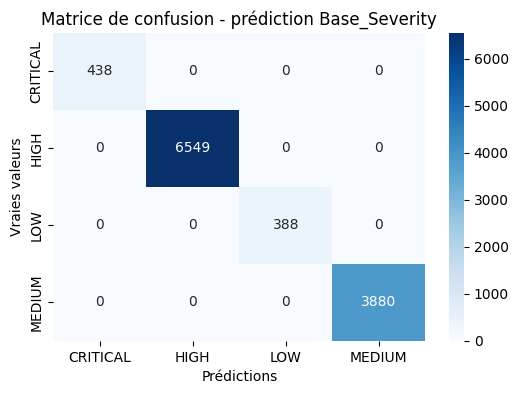

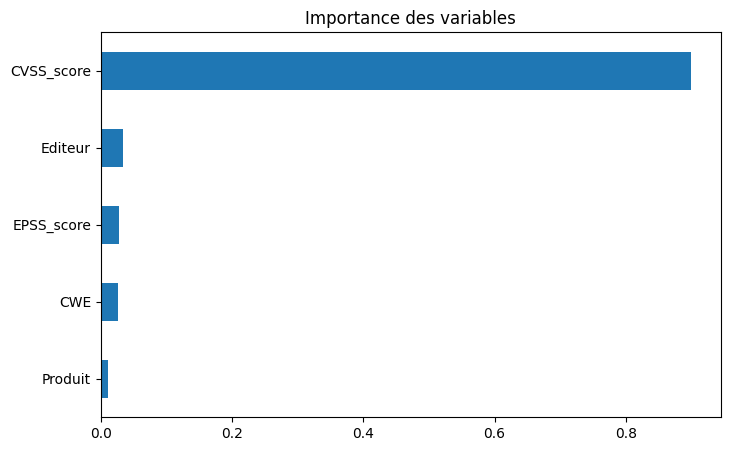

In [12]:
# Supervisé - Random Forest

df_model = df[["Base_Severity", "CVSS_score", "EPSS_score", "CWE", "Editeur", "Produit"]].dropna()
df_model = df_model[df_model["Base_Severity"].isin(["LOW", "MEDIUM", "HIGH", "CRITICAL"])]

label_encoders = {}
for col in ["CWE", "Editeur", "Produit"]:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))
    label_encoders[col] = le

le_severity = LabelEncoder()
df_model["Base_Severity"] = le_severity.fit_transform(df_model["Base_Severity"])
X = df_model.drop("Base_Severity", axis=1)
y = df_model["Base_Severity"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # Train / Test split
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy :", accuracy_score(y_test, y_pred))
print("\nClassification Report :\n", classification_report(y_test, y_pred, target_names=le_severity.classes_))

conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues", xticklabels=le_severity.classes_, yticklabels=le_severity.classes_)
plt.title("Matrice de confusion - prédiction Base_Severity")
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.show()

importances = pd.Series(clf.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).plot(kind='barh', figsize=(8, 5), title="Importance des variables")
plt.show()

On remarque que l'accuracy globale atteint 1.00, indiquant que toutes les prédictions sur l’ensemble de test sont correctes. La matrice de confusion confirme cela : chaque classe (LOW, MEDIUM, HIGH, CRITICAL) est parfaitement prédite, sans aucune erreur de classificatio (la diagonale principale contient 100 % des valeurs)

Le classification report renforce cette observation avec des scores parfaits pour chaque classe :

- Precision = 1.00 : le modèle ne se trompe pas quand il prédit une classe

- Recall = 1.00 : il détecte correctement toutes les occurrences d’une classe

- F1-score = 1.00 : parfait équilibre entre précision et rappel

Un score de 100 % sur l’ensemble de test peut indiquer un surapprentissage (overfitting), notamment si le dataset contient des patterns très simples ou si les classes sont prédictibles à partir d’une seule variable (ici, CVSS_score)

En effet, ces performances s'expliquent ici car la variable cible (Base_Severity) est dérivée directement du score CVSS_score, qui est également utilisé comme variable explicative. Ce lien logique rend la tâche de prédiction quasi triviale pour l’algorithme. La courbe d’importance des variables confirme d’ailleurs que CVSS_score est la variable prédominante dans la décision, éclipsant les autres facteurs comme EPSS_score, Produit ou CWE.

Ce modèle n’est pas inutile, mais il n’apporte pas une "prédiction intelligente" car il reproduit simplement une logique déjà codée dans les données. Il est donc plus adapté à une tâche de vérification ou d’automatisation que d’inférence complexe.

## 3.1 – Machine Learning supervisé 2 : Prédiction du score EPSS

L’objectif ici est d’entraîner un modèle de régression supervisée capable de prédire la probabilité d’exploitation d’une vulnérabilité (EPSS_score) à partir d’informations disponibles comme le niveau de gravité ou le type de vulnérabilité.
Cette prédiction est utile pour anticiper le risque réel associé à une faille, même lorsque l’EPSS officiel n’est pas encore publié.

- Variable cible :
    - EPSS_score : probabilité (entre 0 et 1) que la faille soit exploitée

- Variables explicatives choisies :
    - CVSS_score : gravité de la vulnérabilité

    - Base_Severity (encodée) : niveau de criticité (LOW, MEDIUM, etc.)

    - CWE ou CWE_description (encodés) : type de faille

    - Produit, Editeur (encodés) : informations sur les systèmes concernés


Ces variables ont été retenues car elles permettent de combiner la gravité de la vulnérabilité, son contexte technique et les entités affectées.

Modèle choisi :

Nous avons utilisé Random Forest Regressor, car :

- Il gère bien les données mixtes (catégorielles encodées + numériques)

- Il est robuste aux valeurs manquantes

- Il fournit de bonnes performances de prédiction sans hypothèse linéaire

- Il permet d’obtenir l’importance des variables

## 3.2 – Validation de notre modèle supervisé (Random Forest Regressor)
Pour évaluer la performance de notre modèle de régression, nous avons séparé notre jeu de données en deux parties :

- 70% pour l’entraînement

- 30% pour le test

Métriques utilisées :
- R² Score (coefficient de détermination) : Évalue la proportion de la variance du EPSS_score expliquée par le modèle (score proche de 1 = excellent modèle)

- RMSE (Root Mean Squared Error) : Mesure l’erreur moyenne entre les prédictions et les valeurs réelles (plus c’est bas, mieux c’est)

- MAE (Mean Absolute Error) : Moyenne des écarts absolus entre la valeur réelle et la valeur prédite

- Graphique : Valeurs prédites vs réelles : Un graphique de dispersion permet de visualiser la précision du modèle (plus les points sont proches de la diagonale, plus les prédictions sont précises)

MAE : 0.0092
RMSE : 0.0611
R² : 0.4095


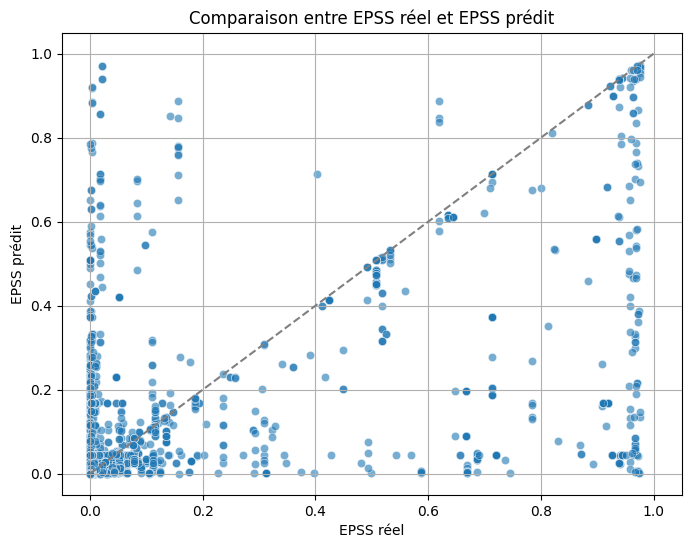

In [16]:
# Supervisé 2 : Prédiction score EPSS
df = df.dropna(subset=["EPSS_score"]) # on retire les lignes sans score EPSS
colonnes_cat = ["Base_Severity", "CWE", "Produit", "Editeur"] #colonnes à encoder
for col in colonnes_cat:
    df[col] = df[col].astype(str)
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

X = df[["CVSS_score", "Base_Severity", "CWE", "Produit", "Editeur"]]
y = df["EPSS_score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Métriques d’évaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"MAE : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R² : {r2:.4f}")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlabel("EPSS réel")
plt.ylabel("EPSS prédit")
plt.title("Comparaison entre EPSS réel et EPSS prédit")
plt.plot([0, 1], [0, 1], '--', color='gray')  # diagonale
plt.grid(True)
plt.show()


Le graphique ci-dessus montre la comparaison entre les scores EPSS réels et ceux prédits par notre modèle de régression. Les points proches de la diagonale indiquent des prédictions précises, tandis que les écarts signalent des erreurs. On remarque que les points avec un score EPSS réel faible (à gauche) tendent à produire des scores prédits plus élevés. En revanche, les vulnérabilités réellement critiques (EPSS élevé) sont souvent sous-estimées par le modèle, ce qui se traduit par des scores prédits trop bas. Tout cela, ainsi que la dispersion importante autour de la diagonale traduit une certaine difficulté du modèle à capturer parfaitement la variabilité du score EPSS.

Les métriques obtenues confirment cette observation :

- MAE (erreur absolue moyenne) = 0.0092 : en moyenne, l'erreur entre la prédiction et la valeur réelle est faible, ce qui est bon

- RMSE (erreur quadratique moyenne) = 0.0606 : les erreurs plus importantes restent rares, car le RMSE est bas


- R² = 0.4199 : environ 42% de la variance du score EPSS est expliquée par notre modèle. Cela montre que les variables utilisées apportent une certaine valeur prédictive, mais d'autres facteurs (non inclus ici) influencent aussi le score EPSS

En conclusion, notre modèle fournit une estimation raisonnable du score EPSS, mais il pourrait être amélioré en intégrant d'autres variables explicatives. En effet, le score EPSS ne dépend pas seulement de caractéristiques techniques comme le CVSS, le type de vulnérabilité (CWE) ou le produit. Il est aussi influencé par des facteurs externes dynamiques comme par exemple :

- l’intérêt des attaquants

- la médiatisation de la faille

- la rapidité de publication des patchs

- la disponibilité d’exploits publics

Ces facteurs ne sont pas présents dans notre dataset, donc le modèle ne peut pas les prendre en compte.